# Pliocene explorations
### This script compute some ensemble mean changes for the midPliocene-eoi400 simulation.

### Note that the data for to enable this notebook to run does not come bundled into the standard repository. Please see https://pmip-p2fvar-analyzer.readthedocs.io/en/latest/data.html for details about how to get hold of them.

### Import packages and define pmip generations and model lists

In [1]:
'''Import packages for loading data, analysing, and plotting'''

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe

import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
#import xlrd
import os
import matplotlib.colors as colors
import seaborn as sns
import scipy
from sklearn.metrics import mean_squared_error
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as FA
import mpl_toolkits.axisartist.grid_finder as GF

import tarfile


In [2]:
#Define pimp generations and model names
pmip_v4='PMIP4'
pmip_v3='PMIP3'
pmip={}
pmip['PMIP4']=['AWI-ESM-1-1-LR',
               'CNRM-CM6-1',
               'CESM2',
               'EC-Earth3-LR',
               'FGOALS-f3-L',
               'FGOALS-g3',
               'GISS-E2-1-G',
               'HadGEM3-GC31-LL',
               'INM-CM4-8',
               'IPSL-CM6A-LR',
               'MIROC-ES2L',
               'MPI-ESM1-2-LR',
               'MRI-ESM2-0',
               'NESM3',
               'NorESM1-F',
               'NorESM2',
               'UofT-CCSM-4']
pmip['PMIP3']=['BCC-CSM1-1',
               'CCSM4',
               'CNRM-CM5',
               'CSIRO-Mk3L-1-2',
               'CSIRO-Mk3-6-0',
               'EC-EARTH-2-2',
               'FGOALS-g2',
               'FGOALS-s2',
               'GISS-E2-R',
               'HadGEM2-CC',
               'HadGEM2-ES',
               'IPSL-CM5A-LR',
               'KCM1-2-2',
               'MIROC-ESM',
               'MPI-ESM-P',
               'MRI-CGCM3']
               
               
#expand out the provided data if there isn't already something there
if not os.path.exists('../data_netcdf/piControl'):
   tar = tarfile.open("../data_netcdf/PMIP4_tas_pr_data.tar.gz")
   tar.extractall(path='../data_netcdf/')
               

## This part define the functions to find files fitting variable and experiment requirements.

In [3]:
#No change needs here
#This cell defines the functions to find variables, models and experiments


#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "../data_netcdf/"
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "../data_netcdf/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "../data_netcdf/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='../data_netcdf/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames

#This function will identify models in the ensemble
def identify_ensemble_members(variable_name,experiment_name):
    datadir="../data_netcdf/%s" %(experiment_name)
    ensemble_members = [] #create an empty list
    with os.scandir(datadir) as entries:
        for entry in entries:
            this_file=xr.open_dataset(entry,decode_times=False,engine="netcdf4")
            if variable_name in list(this_file.keys()):
                ensemble_members.append(datadir+"/"+entry.name)
            this_file.close()
    return ensemble_members

#This function will list extract model name
def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

#This function will collect member models which have the variable in the experiment
def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    


## This part defines functions to calculate ensemble averages and SDs

In [4]:
#No change needs here
#This cell defines the functions to calculate ensembel averages and averaged changes


#This function will calculate the ensemble average
def ensemble_mean(pmip_v,variable_name,experiment_name):
    n=0
    average=0
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-0, 360, 1.0))})
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    for gcm in gcm_dict:
        if gcm in pmip[pmip_v]:
            this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
            this_var=this_file[variable_name]
            this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
            var_1x1=this_regridder(this_var)
            average=(n*average+var_1x1)/(n+1)
            n=n+1
    return average

#This function will calculate the difference between experiment and piControl for each model, 
#and then calculate the ensemble average of the differences
def ensemble_mean_diffence(pmip_v,experiment_name,variable_name):
    model_list=[]
    n=0
    average=0
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
                diff_1x1=this_regridder(diff)
                if n==0:
                    average=diff_1x1
                else:
                    average=(n*average+diff_1x1)/(n+1)
                n=n+1
    return average

#This function will calculate the difference between experiment and piControl for each model, 
#and then calculate the ensemble stddev of the differences
def ensemble_stddev(pmip_v,experiment_name,variable_name):
    model_list=[]
    dataset=[]
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
                diff_1x1=this_regridder(diff)
                dataset.append(diff_1x1)
    data=np.array(dataset)
    std=diff_1x1
    std.values=np.std(data,axis=0)
    return std


In [8]:
#No change needs here

'''Define plotting functions'''
#This fuction will plot Robinson projected Geo2D map for averaged temperature in deg_C
def var_plot(data,experiment_name,variable_name,clim,cmap):
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    print(clim)
    bounds = np.linspace(clim[0], clim[1], 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(10, 6), subplot_kw={'projection': ccrs.Robinson()})
    title='%s %s' %(experiment_name,variable_name)
    axs.set_title(title)
    axs.coastlines()
    axs.gridlines()
    fig=axs.contourf(data.lon,data.lat,data,levels=10,transform=transform,cmap=cmap,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes(axs,location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig, cax=cax, **kw)
    figname='%s_%s_change.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    

#Same as above but for uncertainty, i.e. stddev
def tas_std_plot(data,experiment_name,variable_name):
    cmap=plt.get_cmap('YlOrRd')
    clim=[0,1.5]
    bounds = np.linspace(0, 1.5, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(10, 6), subplot_kw={'projection': ccrs.Robinson()})
    title= 'PMIP4 Std. Dev.' 
    axs.set_title(title)
    axs.coastlines()
    axs.gridlines()
    fig=axs.contourf(data.lon,data.lat,data, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes(axs,location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig, cax=cax, **kw,extend='max')
    figname='%s_%s_std.png' %(experiment_name,variable_name)
    plt.savefig(figname)

#  Calculations - annual mean temperature
_Note: the first cell below, which is performing the actual calculations, can take a couple of minutes._
       _Please be patient - we have prioritised ease of sharing over computational efficiency_ 

/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'amm_pr_regression_mon' has multiple fill values {-1073741800.0, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'amm_tas_regression_mon' has multiple fill values {-1073741800.0, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'amo_pr_regression_lowpass_mon' has multiple fill values {-1073741800.0, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'amo_pr_regression_mon' has multiple fill values {-1073741800.0, 1e+20}, dec

[-0.25, 0.25]


/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/ucfaccb/minicond

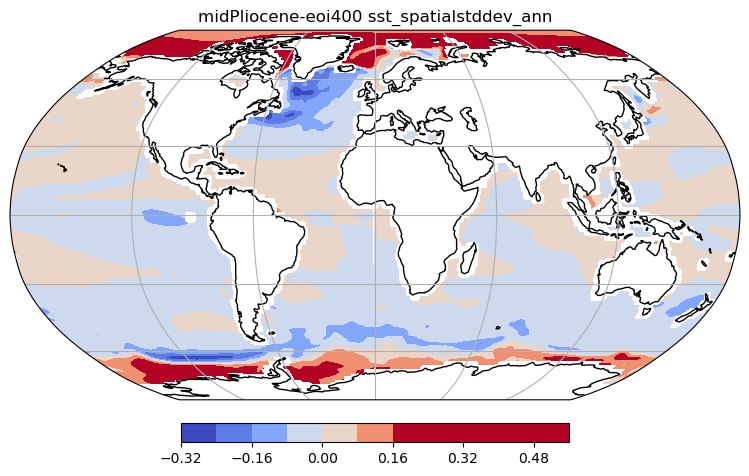

In [10]:
'''Set experiment and variable names'''
experiment_name='midPliocene-eoi400'
variable_name='sst_spatialstddev_ann'

'''calculations'''
#PMIP4
sst_variability=ensemble_mean_diffence(pmip_v4,experiment_name,variable_name)
sst_var_plot=var_plot(sst_variability,experiment_name,variable_name,[-0.25,0.25],plt.get_cmap('coolwarm'))

In [7]:
'''Annual mean temperature difference: ensemble variation PMIP4.
It shows the standard deviation across the ensemble (i.e. between model's mean difference in midHolocene minus piControl) in annual mean temperature change.'''

tas_std_plot(tas_ann_ensemble_std_v4,experiment_name,variable_name)

NameError: name 'tas_ann_ensemble_std_v4' is not defined